<a href="https://colab.research.google.com/github/kilarson/Google_Colab/blob/main/phangs_sundogfun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Example notebook accessing the Sundog visualization server for PHANGS galaxies

Access the Sundog interactive display for any galaxy in the PHANGS-HST program from the PHANGS data [webpage](https://archive.stsci.edu/hlsp/phangs) and selecting the 'interactive display' option next to any galaxy.

Author: Dave Thilker, JHU

Date: April 18, 2024


In [ ]:
#if using this code in .py form rather than .ipynb, or the .ipynb in jupyter notebook... COMMENT OUT the 'pip install' lines
#if using this code as .ipynb in jupyter notebook rather than google colab... UNCOMMENT %matplotlib notebook line if you want interactivity

#select PHANGS-HST galaxy
#for now limited to ngc1566, ngc1559, ngc1433, ngc3351, ngc3627  due to reliance on currently public PHANGS MSA catalogs, and
galaxystr='ngc1566'  #in the case of ngc3351 and ngc3627, must tack 'mosaic' onto the end of galaxystr (e.g. 'ngc3351mosaic') due to the viewer file names
galaxy=galaxystr.replace('mosaic','')

In [ ]:
#%matplotlib notebook

import numpy as np
from astropy.io import fits
import glob
import urllib3
import matplotlib.pyplot as plt

In [ ]:
import os
#needed in order to use os.system
from IPython.display import Javascript
Javascript('''google.colab.output.enable(true);''')

<IPython.core.display.Javascript object>

In [ ]:
os.system('pip install astroquery')
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy import units as u
from astroquery.ned import Ned

result_table = Ned.query_object(galaxy)
print(result_table) # an astropy.table.Table
rastr=str(round(result_table['RA'][0], 5))
decstr=str(round(result_table['DEC'][0], 5))

No. Object Name     RA     ... Redshift Points Diameter Points Associations
                 degrees   ...                                             
--- ----------- ---------- ... --------------- --------------- ------------
  1    NGC 1566   65.00175 ...              47              17            0


<ipython-input-4-c51394f055d2>:5: DeprecationWarning: the ``ned`` module has been moved to astroquery.ipac.ned, please update your imports.
  from astroquery.ned import Ned


In [ ]:
# download sundog cutouts in png, RGBfits, and F275W-only FITS format (the later is for WCS purposes)

url = 'https://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f814w_v1_exp-drc-sci.fits&green=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f555w_v1_exp-drc-sci.fits&blue=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f438w_v1_exp-drc-sci.fits&align=1&reference=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f275w_v1_exp-drc-sci.fits&maxzoom=5&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size=3000,1800&zoom=1.0'
http = urllib3.PoolManager()

with http.request('GET', url, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open('sundog.png', 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

urlfits=url.replace('png','fits')

with http.request('GET', urlfits, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open('sundog.fits', 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

url275fits = 'https://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f275w_v1_exp-drc-sci.fits&maxzoom=5&tile=&download=1&format=fits&ra='+rastr+'&dec='+decstr+'&corner=0&size=3000,1800&zoom=1.0'

with http.request('GET', url275fits, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open('sundog_f275w.fits', 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")


Downloaded 100.00%
Downloaded 100.00%
Downloaded 100.00%


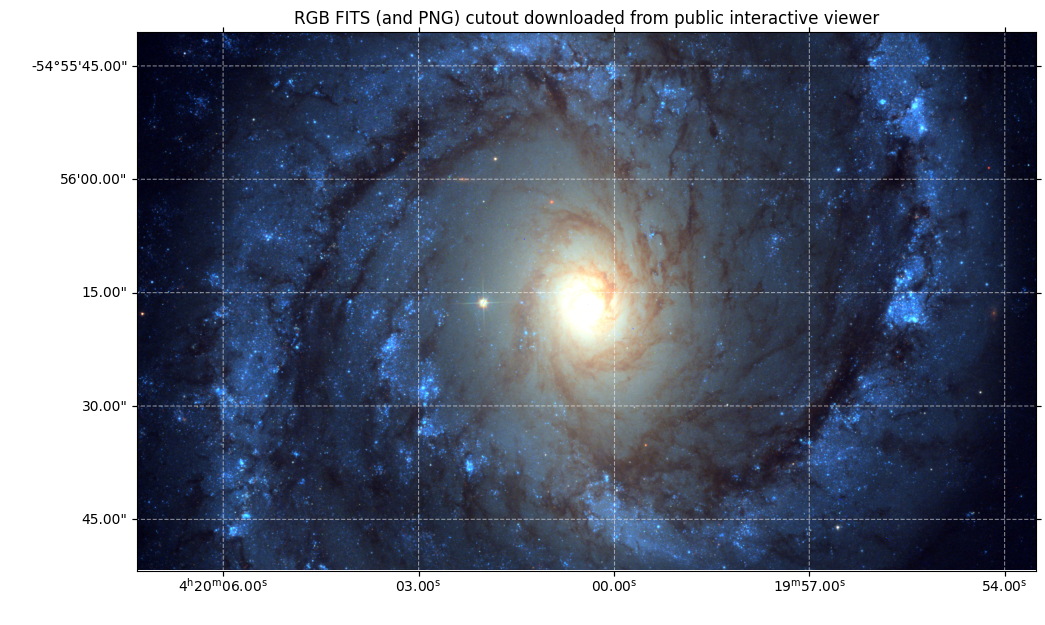

In [ ]:
# read the downloaded png image and display it with WCS coordinates from the downloaded F275W fits file header

from astropy.visualization import ImageNormalize, AsinhStretch
from astropy.wcs import WCS

image_data = plt.imread('sundog.png')

# Flip the image vertically.  --OTHERWISE IMAGE AND WCS DO NOT AGREE
image_data = np.flipud(image_data)

with fits.open('sundog_f275w.fits') as hdul:
    wcs = WCS(hdul[0].header)#.dropaxis(2) #DROPAXIS FOR RGBfits ONLY

norm = ImageNormalize(image_data, stretch=AsinhStretch())

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image_data, origin='lower', norm=norm)

ax.coords['ra'].set_major_formatter('hh:mm:ss.ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss.ss')

ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_xlabel('RA (J2000)', color='white')
ax.set_ylabel('Dec (J2000)', color='white')

ax.set_title('RGB FITS (and PNG) cutout downloaded from public interactive viewer')
plt.show()


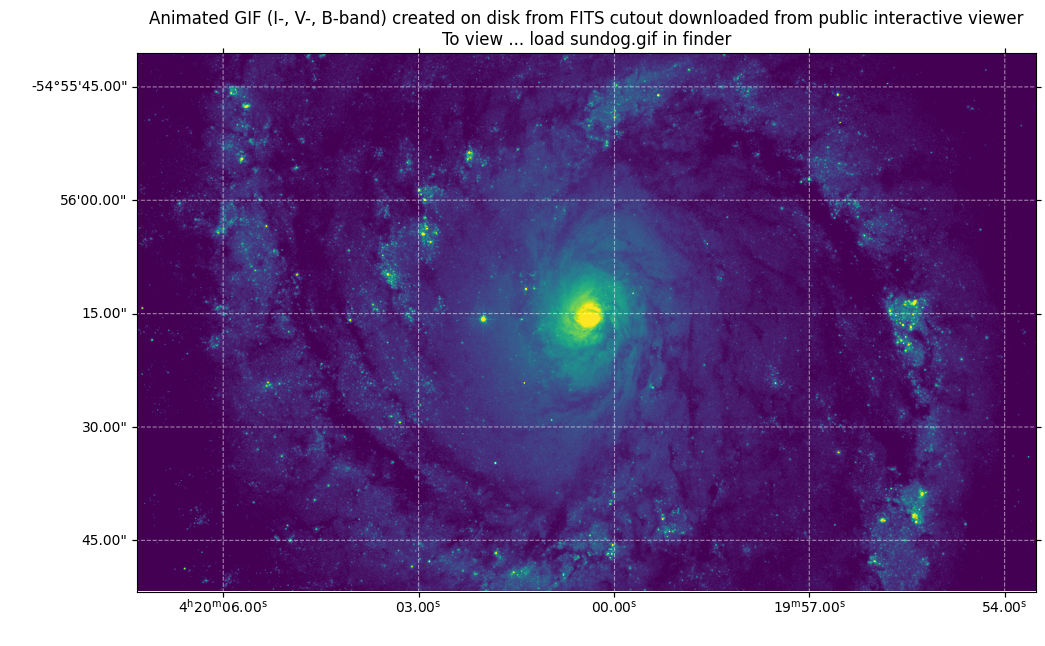

In [ ]:
# display the downloaded multi-extension RGB fits file as an animated gif

from matplotlib import animation
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)

with fits.open('sundog.fits') as hdul:
  ims = []
  for i in range(hdul[0].data.shape[0]):
    image_data_band=hdul[0].data[i, :, :]
    image_data_band=np.flipud(image_data_band)  # DESPITE FLIPPING THE SINGLE BANDS, THE IMAGE IN THE ANIMATED GIF IS UPSIDE DOWN!!!
    im = ax.imshow(image_data_band, origin='lower', norm=norm)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=5000)

ax.coords['ra'].set_major_formatter('hh:mm:ss.ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss.ss')

ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_xlabel('RA (J2000)', color='white')
ax.set_ylabel('Dec (J2000)', color='white')

ax.set_title('Animated GIF (I-, V-, B-band) created on disk from FITS cutout downloaded from public interactive viewer\nTo view ... load sundog.gif in finder')

#saved GIF can be viewed as animated in the mac 'finder' application
ani.save('sundog.gif', writer='pillow')

plt.show()


In [ ]:
# interpret a string containing a sequence of floats as a series of x,y vertices

import re

def interpret_vertices(vertex_string):
  """
  Interprets a string containing a sequence of floats as a series of x,y vertices.

  Args:
    vertex_string: A string containing a sequence of floats, separated by spaces.

  Returns:
    A list of tuples, where each tuple represents an (x, y) vertex.
  """

  # Remove any non-numeric characters from the string.
  vertex_string = re.sub(r"[^\d\s\.\-]", "", vertex_string)

  # Split the string into a list of floats.
  vertices = vertex_string.split()

  # Convert the list of floats into a list of tuples.
  vertices = [(float(vertices[i]), float(vertices[i+1])) for i in range(0, len(vertices), 2)]

  return vertices

# Example usage:
#vertex_string = "10 10 20 20 30 30"
#vertices = interpret_vertices(vertex_string)
#print(vertices)

In [ ]:
# download https://archive.stsci.edu/hlsps/phangs-cat/bundles/hlsp_phangs-cat_hst_wfc3_'+galaxy+'_multi_v1_assoc-cats.tar.gz and unpack into a subdirectory called cluster_catalogs
os.system('mkdir assoc_catalogs')

url = 'https://archive.stsci.edu/hlsps/phangs-cat/bundles/hlsp_phangs-cat_hst_wfc3_'+galaxy+'_multi_v1_assoc-cats.tar.gz'
http = urllib3.PoolManager()

with http.request('GET', url, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open(url.replace('https://archive.stsci.edu/hlsps/phangs-cat/bundles/',''), 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

print('Unpacking...')
os.system('tar -xzvf hlsp_phangs-cat_hst_wfc3_'+galaxy+'_multi_v1_assoc-cats.tar.gz -C assoc_catalogs')
for item in glob.glob('assoc_catalogs/**/**', recursive=True): print(item)

Downloaded 100.00%
Unpacking...
assoc_catalogs/
assoc_catalogs/ngc3627
assoc_catalogs/ngc3627/hlsp_phangs-cat_hst_wfc3_all_multi_v1_assoc-readme.txt
assoc_catalogs/ngc3627/assoc
assoc_catalogs/ngc3627/assoc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-brightstarmask.reg
assoc_catalogs/ngc3627/assoc/vselect
assoc_catalogs/ngc3627/assoc/vselect/ws32pc
assoc_catalogs/ngc3627/assoc/vselect/ws32pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws32pc-main.fits
assoc_catalogs/ngc3627/assoc/vselect/ws32pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws32pc-idmask.fits
assoc_catalogs/ngc3627/assoc/vselect/ws32pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws32pc-peaks.reg
assoc_catalogs/ngc3627/assoc/vselect/ws32pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws32pc-region.reg
assoc_catalogs/ngc3627/assoc/vselect/ws64pc
assoc_catalogs/ngc3627/assoc/vselect/ws64pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws64pc-main.fits
assoc_catalog

In [ ]:
from matplotlib.patches import Polygon
import glob

msafile=glob.glob('*/*/*/*/*/*'+galaxy+'*nuv*ws64pc*region.reg',recursive=True)
#print(msafile)
with open(msafile[0]) as f:
    shapes = []
    for line in f:
        if line.startswith(' polygon'):
            vertices = interpret_vertices(line)
            #print(vertices)
            shapes.append(Polygon(vertices))
    #print(shapes)

In [ ]:
# convert the matplotlib polygons defined as right acension declination in the shapes list to PolygonSkyRegions
os.system('pip install regions')
from astropy.coordinates import SkyCoord
from regions import PolygonSkyRegion

def convert_polygon_to_sky_region(polygon):
  """
  Converts a matplotlib Polygon to an astropy.coordinates.PolygonSkyRegion.

  Args:
    polygon: A matplotlib Polygon object.

  Returns:
    An astropy.coordinates.PolygonSkyRegion object.
  """

  # Get the vertices of the polygon.
  vertices = np.array(polygon.get_xy()).T

  # Convert the vertices to sky coordinates.
  sky_coords = SkyCoord(vertices[0], vertices[1], frame='icrs', unit='deg')

  # Create a PolygonSkyRegion object.
  sky_region = PolygonSkyRegion(sky_coords)#, frame='icrs')

  return sky_region

# Convert the matplotlib polygons to PolygonSkyRegions.
sky_regions = [convert_polygon_to_sky_region(polygon) for polygon in shapes]

# Print the PolygonSkyRegions.
#for sky_region in sky_regions:
#  print(sky_region)


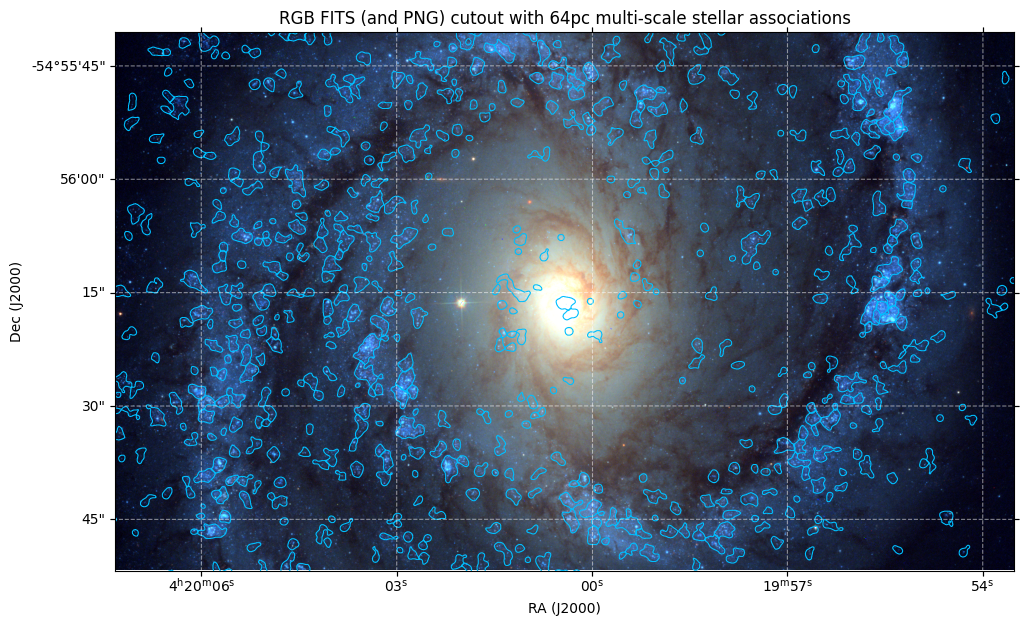

In [ ]:
# read the downloaded png image and display it with WCS coordinates from the downloaded F275W fits file header, then overplot each PolygonSkyRegion in sky_regions

# Read the downloaded PNG image.
image_data = plt.imread('sundog.png')

# Flip the image vertically.  --OTHERWISE IMAGE AND WCS+REGIONS DO NOT AGREE
image_data = np.flipud(image_data)

# Get the WCS coordinates from the downloaded FITS file header.
with fits.open('sundog_f275w.fits') as hdul:
    wcs = WCS(hdul[0].header)#.dropaxis(2) #DROPAXIS FOR RGBfits ONLY

# Create a figure and axes.
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)

# Display the image with WCS coordinates.
ax.imshow(image_data, origin='lower')

# Overplot each PolygonSkyRegion.
for sky_region in sky_regions:
    pixel_region = sky_region.to_pixel(wcs)
    pixel_region.plot(ax=ax, facecolor='none', edgecolor='deepskyblue', linewidth=0.75)
    #sky_region.plot(ax=ax, facecolor='none', edgecolor='red')

# Set the labels and grid.
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_title('RGB FITS (and PNG) cutout with 64pc multi-scale stellar associations')


# Show the plot.
plt.show()


In [ ]:
# download https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/hlsp_phangs-cat_hst_acs-uvis_'+galaxy+'_multi_v1_cats.tar.gz and unpack into a subdirectory called cluster_catalogs
os.system('mkdir cluster_catalogs')

url = 'https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/hlsp_phangs-cat_hst_acs-uvis_'+galaxy+'_multi_v1_cats.tar.gz'
http = urllib3.PoolManager()

with http.request('GET', url, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open(url.replace('https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/',''), 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

print('Unpacking...')
os.system('tar -xzvf hlsp_phangs-cat_hst_acs-uvis_'+galaxy+'_multi_v1_cats.tar.gz -C cluster_catalogs')
for item in glob.glob('cluster_catalogs/**/**', recursive=True): print(item)

Downloaded 100.00%
Unpacking...
cluster_catalogs/
cluster_catalogs/catalogs
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-compact-association-class3.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc1559_multi_v1_obs-machine-cluster-class12.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-machine-cluster-class12.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc3351_multi_v1_obs-machine-cluster-class12.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc1566_multi_v1_obs-machine-compact-association-class3.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc1559_multi_v1_obs-machine-compact-association-class3.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-cluster-class12.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-machine-compact-association-class3.fits
cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_ngc1559_multi_v1_obs-huma

In [ ]:
# read hlsp_phangs-cat_hst_uvis_'+galaxy+'_multi_v1_obs-machine-cluster-class12.fits using astropy.table

from astropy.table import Table

cluster_cat = Table.read('cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_'+galaxy+'_multi_v1_obs-machine-cluster-class12.fits')
#print(cluster_cat)


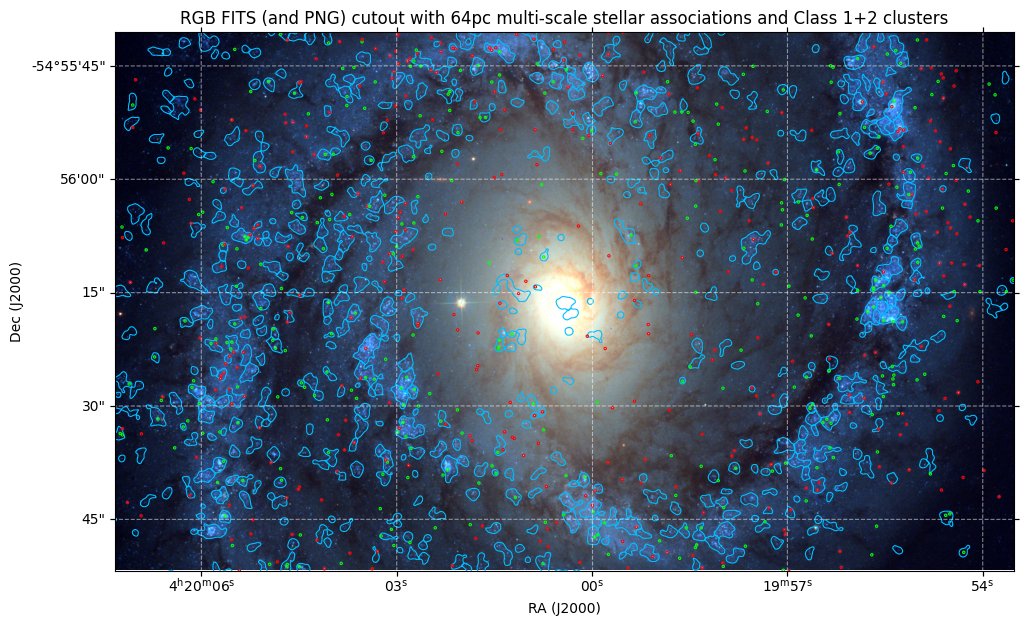

In [ ]:
from regions import CircleSkyRegion
from astropy import units as u

# Convert the astropy table to a list of CircleSkyRegions.
circle_sky_regions = []
for row in cluster_cat:
  circle_sky_regions.append(CircleSkyRegion(
    SkyCoord(row['PHANGS_RA'], row['PHANGS_DEC'], frame='icrs', unit='deg'),
    radius=4.*0.03962 * u.arcsec
  ))

# Read the downloaded PNG image.
image_data = plt.imread('sundog.png')

# Flip the image vertically.  --OTHERWISE IMAGE AND WCS+REGIONS DO NOT AGREE
image_data = np.flipud(image_data)

# Get the WCS coordinates from the downloaded FITS file header.
with fits.open('sundog_f275w.fits') as hdul:
    wcs = WCS(hdul[0].header)#.dropaxis(2) #DROPAXIS FOR RGBfits ONLY

# Create a figure and axes.
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)

# Display the image with WCS coordinates.
ax.imshow(image_data, origin='lower')

# Overplot each PolygonSkyRegion.
for sky_region in sky_regions:
    pixel_region = sky_region.to_pixel(wcs)
    pixel_region.plot(ax=ax, facecolor='none', edgecolor='deepskyblue', linewidth=0.75)
    #sky_region.plot(ax=ax, facecolor='none', edgecolor='red')

# Overplot each CircleSkyRegion on the display of sundog.png, changing color according to cluster morphological class
for idx, circle_sky_region in enumerate(circle_sky_regions):
  pixel_region = circle_sky_region.to_pixel(wcs)
  if cluster_cat['PHANGS_CLUSTER_CLASS_ML_VGG'][idx]==1: clustercolor='red'
  if cluster_cat['PHANGS_CLUSTER_CLASS_ML_VGG'][idx]==2: clustercolor='lime'
  pixel_region.plot(ax=ax, facecolor='none', edgecolor=clustercolor, linewidth=0.75)

# Set the labels and grid.
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_title('RGB FITS (and PNG) cutout with 64pc multi-scale stellar associations and Class 1+2 clusters')

# Show the plot.
plt.show()


In [ ]:
# randomly select nclust rows from cluster_cat and generate a subset catalog

nclust = 16
cluster_cat_subset = cluster_cat[np.random.randint(len(cluster_cat), size=nclust)]

In [ ]:
# fetch the cluster subimages
# for this demonstration just autoscale, do not tune RGB intensity transfer functions/limits to produce equivalent hue for equivalent relative intensity ratios

refband = 'f275w' #HST F275W NUV   # in the present implementation this produces F814W/F555W/F438W RGB subimages on HST pixel grid
#refband = 'f200w' #JWST NIRCam F200W NIR  # produces F300M/F200W/F814W RGB subimages on NIRCam-short pixel grid (matching extent to HST-only subimages)

# Create a list to store 29 HST-pixel wide subimages, or 37 NIRCam-short-pixel wide subimages
subimages = []

print('Downloading '+str(nclust)+' cluster subimages...')
for idx, clusterid in enumerate(cluster_cat_subset):

  if refband == 'f275w': npix=29
  if refband == 'f200w': npix=37
  npixstr=str(npix)
  rastr=str(cluster_cat_subset['PHANGS_RA'][idx])
  decstr=str(cluster_cat_subset['PHANGS_DEC'][idx])

  if refband == 'f275w': url = 'https://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f814w_v1_exp-drc-sci.fits&green=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f555w_v1_exp-drc-sci.fits&blue=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f438w_v1_exp-drc-sci.fits&align=1&reference=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f275w_v1_exp-drc-sci.fits&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size='+npixstr+'&zoom=1'
  if refband == 'f200w': url = 'https://sundog.stsci.edu/cgi-bin/fitscut.cgi?red=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff300m%2F'+galaxystr+'_nircam_f300m_i2d.fits&green=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff200w%2F'+galaxystr+'_nircam_f200w_i2d.fits&blue=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff814w%2F'+galaxystr+'_uvis_f814w_exp_drc_sci.fits&align=1&reference=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff200w%2F'+galaxystr+'_nircam_f200w_i2d.fits&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size='+npixstr+'&zoom=1.0'
  http = urllib3.PoolManager()

  with http.request('GET', url, preload_content=False) as response:
    content_length = response.info()['Content-Length']
    bytes_so_far = 0

    with open('sundog_subimage.png', 'wb') as f:
      for chunk in response.stream(32768):
        bytes_so_far += len(chunk)
        f.write(chunk)

  image_data = plt.imread('sundog_subimage.png')
  image_data = np.flipud(image_data)
  subimages.append(image_data)

print('Complete!')

Complete!


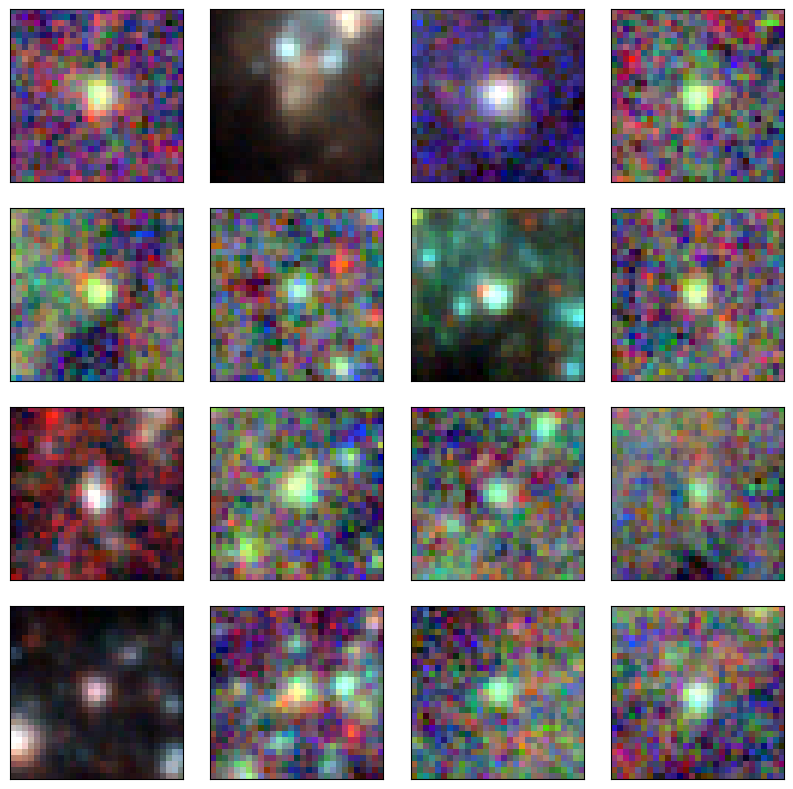

In [ ]:
# display the cluster subimages as a roughly square montage

gridsize=int(np.ceil(np.sqrt(nclust)))
fig, axes = plt.subplots(gridsize, gridsize, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if (i+1 <= nclust):
      ax.imshow(subimages[i], origin='lower')
      ax.set_xticks([])
      ax.set_yticks([])
    else: ax.set_axis_off()

plt.subplots_adjust(hspace=0.15, wspace=0.15)
plt.show()
